In [1]:
import jax.numpy as np
import jax
from jax.config import config
config.update("jax_debug_nans", True)  # https://github.com/google/jax/issues/475#issuecomment-470417985
# config.update('jax_platform_name', 'cpu')  # https://github.com/google/jax/issues/1598#issuecomment-718621972

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import razor

In [2]:
visible_spectrum = np.linspace(380, 750, 100) * 1e-9

def wyman(a, b, c, d, lam):
#     https://jcgt.org/published/0002/02/01/
    return a * np.exp(-0.5 * (
        (lam - b) *
        np.where(lam - b < 0, c, d)
    ) ** 2)

cie_X = wyman( 0.362, 442.0, 0.0624, 0.0374, visible_spectrum * 1e9) +\
        wyman( 1.056, 599.8, 0.0264, 0.0323, visible_spectrum * 1e9) +\
        wyman(-0.065, 501.1, 0.0490, 0.0382, visible_spectrum * 1e9)

cie_Y = wyman( 0.821, 568.8, 0.0213, 0.0247, visible_spectrum * 1e9) +\
        wyman( 0.286, 530.9, 0.0613, 0.0322, visible_spectrum * 1e9)

cie_Z = wyman( 1.217, 437.0, 0.0845, 0.0278, visible_spectrum * 1e9) +\
        wyman( 0.681, 459.0, 0.0385, 0.0725, visible_spectrum * 1e9)

def spectrum_to_XYZ(spec):
    xyz = np.stack([
        np.dot(cie_X, spec),
        np.dot(cie_Y, spec),
        np.dot(cie_Z, spec)
    ]) / spec.size
    xyz = xyz / xyz[1]
    return xyz

def XYZ_to_RGB(xyz):
    return np.matmul(
        np.array([
            [+3.2406, -1.5372, -0.4986],
            [-0.9689, +1.8759, +0.0415],
            [+0.0557, -0.2040, +1.0570]
        ]),
        xyz
    )

def planck(T):
#     https://github.com/mitsuba-renderer/mitsuba/blob/cfeb7766e7a1513492451f35dc65b86409655a7b/src/libcore/spectrum.cpp#L483
    c = 299792458.
    k = 1.3806488e-23
    h = 6.62606957e-34
    lam = visible_spectrum
    I = (2 * h * c ** 2) / (lam ** 5) / (np.exp((h / k) * c / (lam * T)) - 1.0)
    return I

def RGB_from_temp(T):
    return XYZ_to_RGB(spectrum_to_XYZ(planck(T)))

In [3]:
cc_a = plt.imread('cc/eraser-a.png')[:, :, :3]
cc_b = plt.imread('cc/eraser-b.png')[:, :, :3]
cc_p = plt.imread('cc/eraser-p.png')[:, :, :3]

def render(cl, ca, cb, cp, big=False, out=False):
    ca = ca
    cb = cb
    cp = cp * np.ones(3)
    cc_a_ = cc_a
    cc_b_ = cc_b
    cc_p_ = cc_p
        
    if not big:
        cc_a_ = jax.image.resize(cc_a_, (128, 128, 3), 'cubic')
        cc_b_ = jax.image.resize(cc_b_, (128, 128, 3), 'cubic')
        cc_p_ = jax.image.resize(cc_p_, (128, 128, 3), 'cubic')

    img = ((ca * cc_a_ + cb * cc_b_ + cp * cc_p_) * cl)
    return img

In [4]:
class model(razor.Model):
    def forward(self, t, observed_img):
        T = t.gaussian_sample(()) * 1000 + 6500
        b = jax.nn.sigmoid(t.uniform_sample(())) * 2.
        cl = RGB_from_temp(T) * b + t.gaussian_sample((3,)) * 0.01
        ca = t.uniform_sample((3,)) * 0.8 + 0.1
        cb = t.uniform_sample((3,)) * 0.8 + 0.1
        img = render(cl, ca, cb, 0)
        t.gaussian_observe(img, 0.1, observed_img)
        
        return (cl, ca, cb)
m = model(cc_p)

(-0.5, 127.5, 127.5, -0.5)

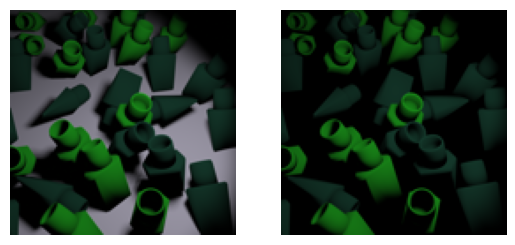

In [5]:
q = jax.random.normal(jax.random.PRNGKey(7), (m.N,))
q_ = m.unpack(q, 0.)
plt.subplot(1, 2, 1)
img = render(*q_, 1.)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
img = render(*q_, 0.)
plt.imshow(img)
plt.axis('off')

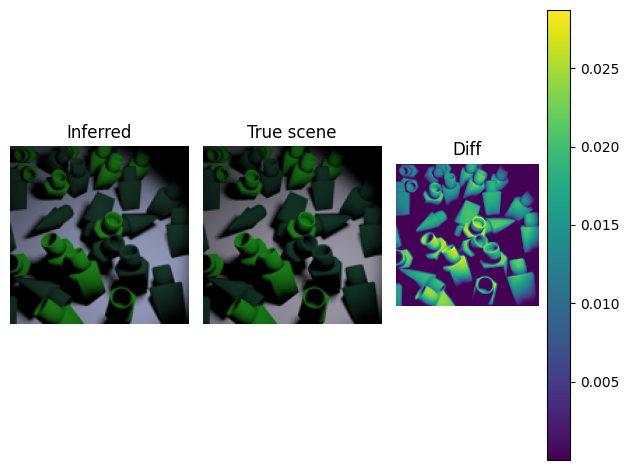

In [6]:
key = jax.random.PRNGKey(0)
q0 = jax.random.normal(key, shape=(m.N,))

N = 20
L = 10

observed_img = img
samples = razor.hmc_sample(
    m, q0, key, N, L, 0, 1e-3,
    observed_img
)[:]
inf = m.unpack(samples[-1], 0.)

plt.subplot(1, 3, 1)
plt.title('Inferred')
plt.imshow(render(*inf, 1.))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('True scene')
plt.imshow(render(*q_, 1.))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Diff')
plt.colorbar(plt.imshow(np.abs((render(*inf, 0.) - observed_img)).sum(axis=2)))
plt.axis('off')
# plt.legend()
plt.tight_layout()

In [7]:
def loss(key, q0, obs):
    obs_ = m.unpack(obs, 0.)
    img = render(*obs_, 0.)
    samples = razor.hmc_sample(
        m, q0, key, 20, 10, 0, 1e-3, img
    )[:]
    inf_ = m.unpack(samples.mean(axis=0), 0.)

    l = 0.
    l = l - np.abs(inf_[1] - obs_[1]).mean()
    l = l - np.abs(inf_[2] - obs_[2]).mean()
    l = l - np.abs((inf_[1] - inf_[1].mean()) - (inf_[2] - inf_[2].mean())).mean() * 0.2
    l = l + np.mean(np.abs(obs)) * 0.01
    return l, (samples, img)
dloss = jax.value_and_grad(loss, argnums=(2), has_aux=True)

In [14]:
pwd

'/Users/ryanpyang/Desktop/966_final_project/optical-illusions'

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

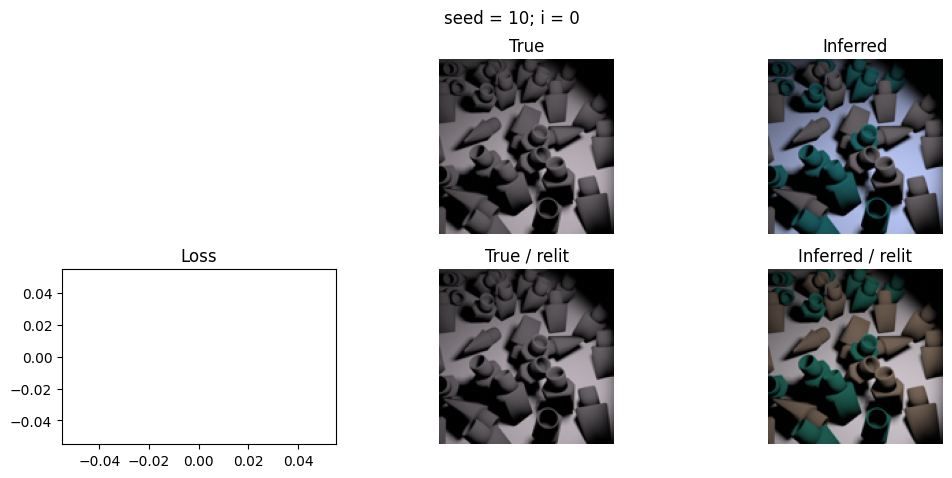

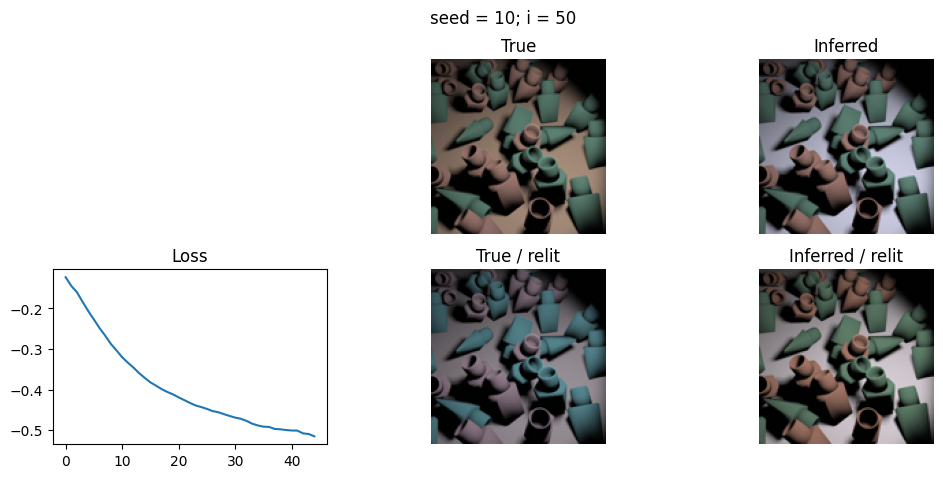

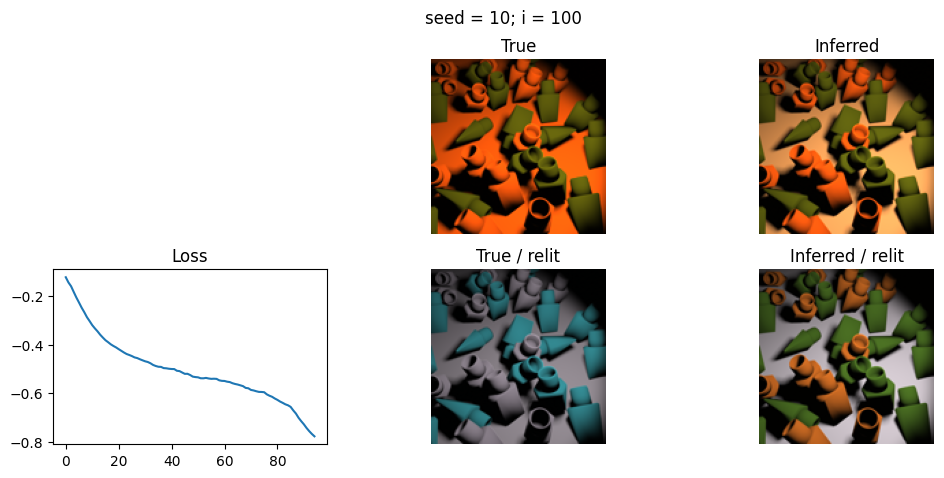

  0%|          | 0/101 [00:00<?, ?it/s]

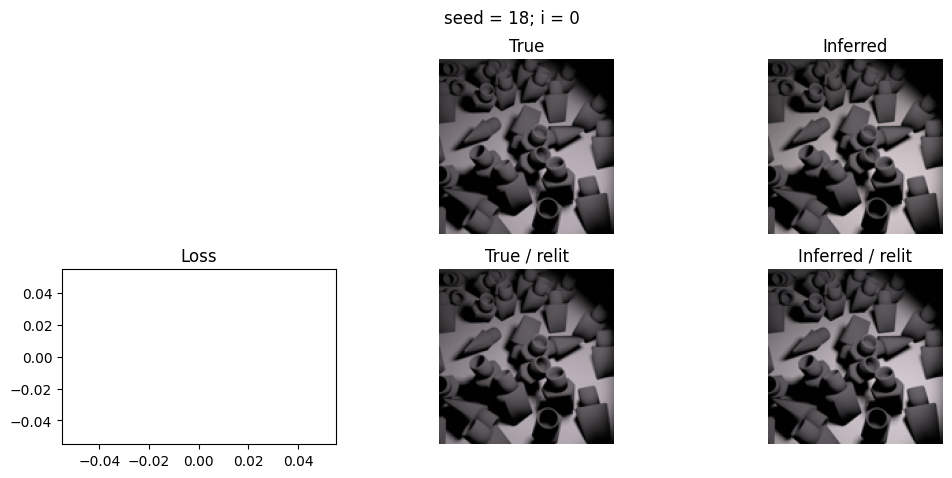

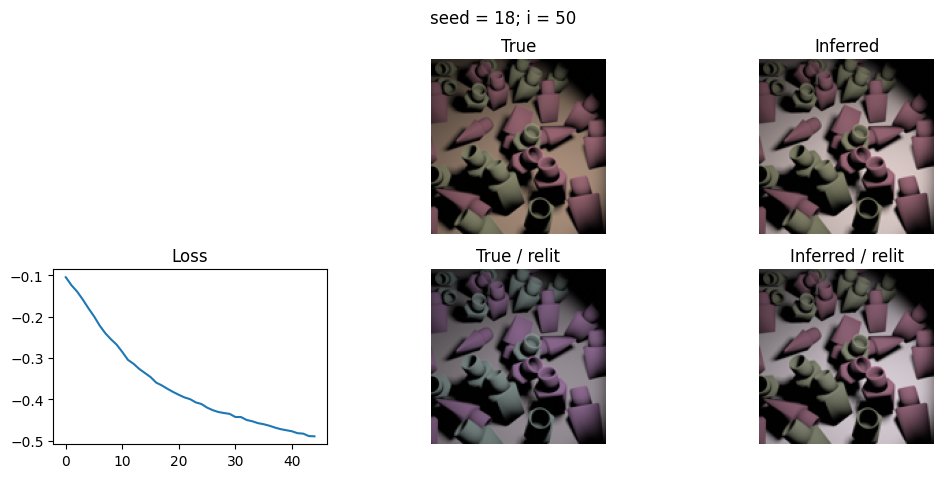

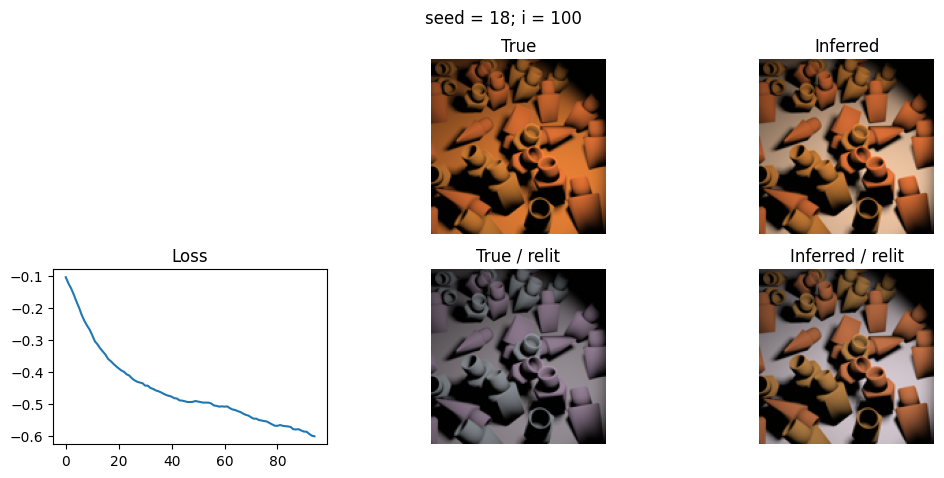

  0%|          | 0/101 [00:00<?, ?it/s]

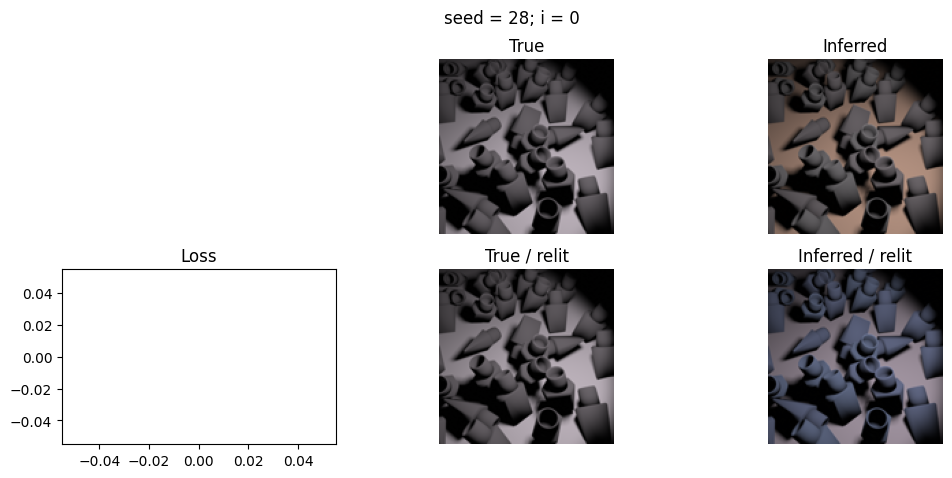

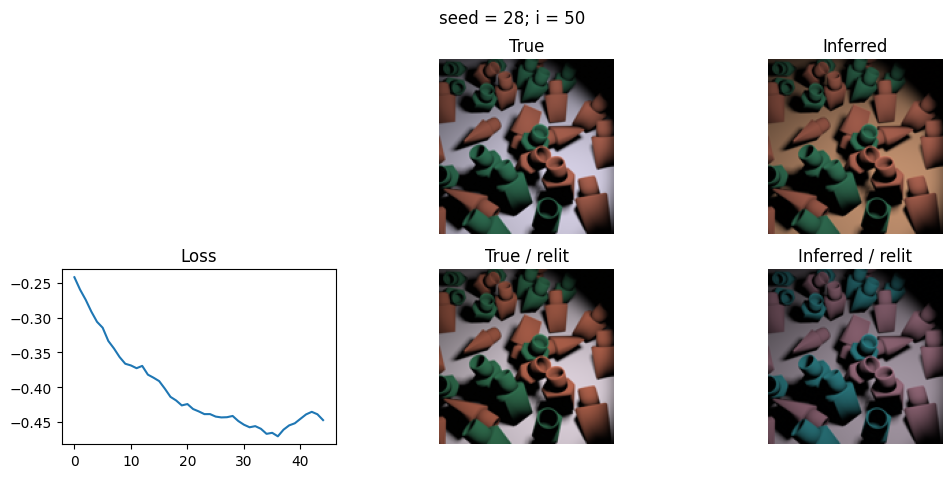

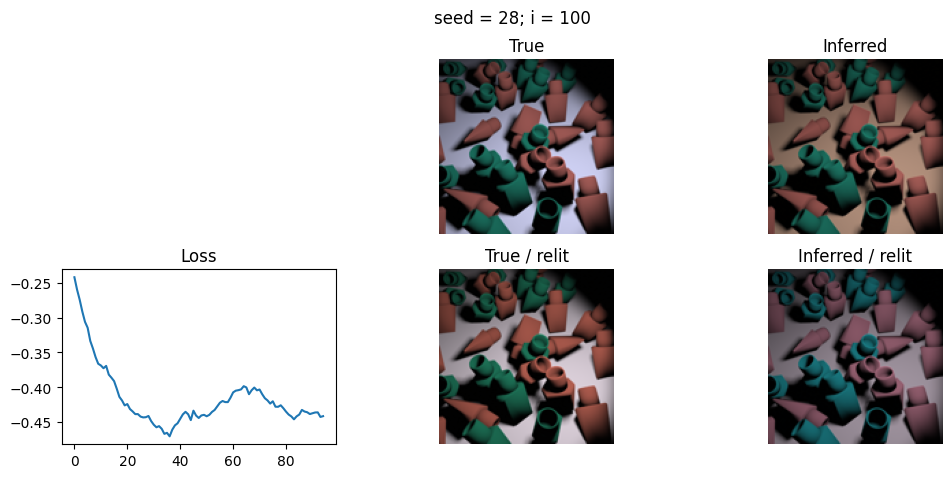

  0%|          | 0/101 [00:00<?, ?it/s]

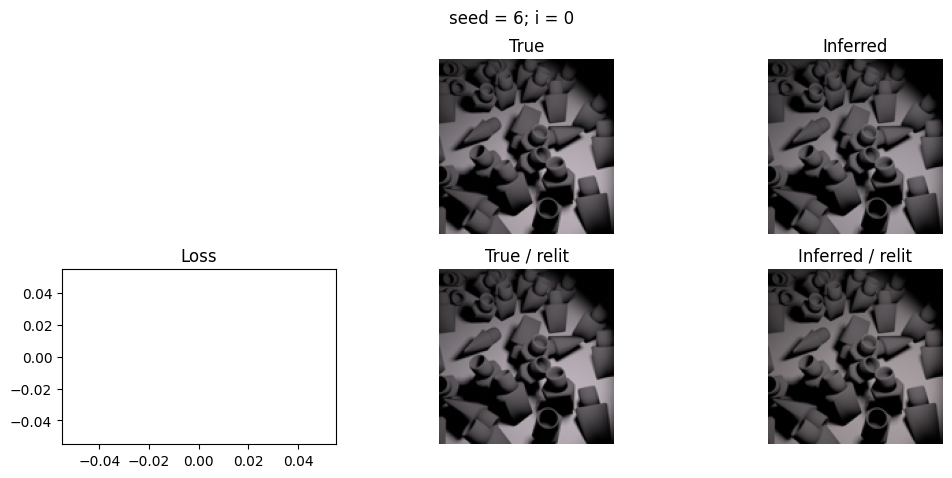

In [ ]:
def safe_show(img):
    plt.imshow(np.clip(img, 0, 1))
    plt.axis('off')

for seed in tqdm([10, 18, 28, 6, 7, 21]):
    key = jax.random.PRNGKey(seed)

    key, subkey = jax.random.split(key)
    q0 = jax.random.normal(subkey, shape=(m.N,))

    key, subkey = jax.random.split(key)
    obs = np.zeros(shape=(m.N,))

    losses = []
    for i in tqdm(range(100 + 1), leave=False):
        key, subkey = jax.random.split(key)
        (l, (samples, img)), dl = dloss(subkey, q0, obs)
        q0 = samples[-1]
        if i > 5:
            losses.append(l)
            obs = obs - 1e0 * dl
        if i % 10 == 0:
            fig = plt.figure(figsize=(12, 5))
            plt.subplot(2, 3, 2); safe_show(render(*m.unpack(obs, img), 1.)); plt.title('True')
            plt.subplot(2, 3, 3); safe_show(render(*m.unpack(samples[-1], img), 1.)); plt.title('Inferred')
            plt.subplot(2, 3, 4); plt.plot(losses, '-'); plt.title('Loss')
            plt.subplot(2, 3, 5); safe_show(render(*m.unpack(obs.at[0].set(0.), img), 1.)); plt.title('True / relit')
            plt.subplot(2, 3, 6); safe_show(render(*m.unpack(samples[-1].at[0].set(0.), img), 1.)); plt.title('Inferred / relit')
            plt.suptitle(f'seed = {seed}; i = {i}')
            if i % 50 == 0:
                from IPython.display import display
                display(fig)
            #plt.savefig(f'out/color-constancy/out-{seed:02}-{i:04}.jpg')
            #plt.imsave( f'out/color-constancy/out-{seed:02}-{i:04}-true.jpg', np.clip(render(*m.unpack(obs, img), 1.), 0, 1))
            #plt.imsave( f'out/color-constancy/out-{seed:02}-{i:04}-true-relit.jpg', np.clip(render(*m.unpack(obs.at[0].set(0.), img), 1.), 0, 1))
            #plt.imsave( f'out/color-constancy/out-{seed:02}-{i:04}-inferred.jpg', np.clip(render(*m.unpack(samples[-1], img), 1.), 0, 1))
            #plt.imsave( f'out/color-constancy/out-{seed:02}-{i:04}-inferred-relit.jpg', np.clip(render(*m.unpack(samples[-1].at[0].set(0.), img), 1.), 0, 1))
            plt.close()